#### **imports**

In [1]:
import pickle
import sys
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict
from collections import Counter
import shap

# Set the random seed
np.random.seed(123)
random_state = 123

# Traditional
from lifelines import KaplanMeierFitter
from lifelines import NelsonAalenFitter
from lifelines import CoxPHFitter

# Tree-Based
from sksurv.ensemble import RandomSurvivalForest

# NN
from pycox.datasets import metabric
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv
from auton_survival.models.dsm import DeepSurvivalMachines
import torchtuples as tt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from lifelines.utils import concordance_index

# Evaluation
from sksurv.metrics import concordance_index_ipcw, brier_score, cumulative_dynamic_auc

# Add the outer directory
sys.path.append('../')
from eval_surv_copy import EvalSurv

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


#### **Load Data**

In [2]:
# Read the pickled DataFrames
with open('data/x_train.pickle', 'rb') as file:
    x_train = pickle.load(file)
with open('data/x_test.pickle', 'rb') as file:
    x_test = pickle.load(file)
with open('data/x_val.pickle', 'rb') as file:
    x_val = pickle.load(file)


# Read the pickled DataFrame
with open('data/consolidated_pat_tbl.pickle', 'rb') as file:
    consolidated_pat_tbl = pickle.load(file)

#### **Non-Param**

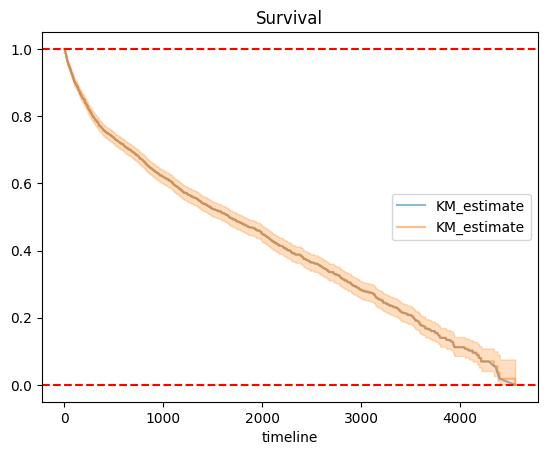

In [3]:
kmf = KaplanMeierFitter()

T = x_train["time_to_event"]
E = x_train["death"]

kmf.fit(T, event_observed=E)

kmf.survival_function_.plot(alpha = 0.5)

plt.title('Survival');

kmf.plot_survival_function(alpha = 0.5);

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

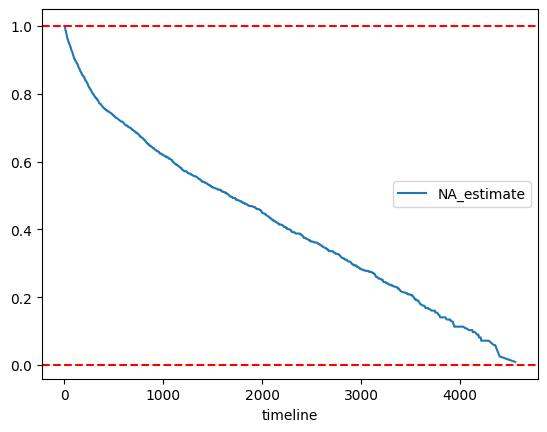

In [4]:
naf = NelsonAalenFitter()

naf.fit(T,event_observed=E)
np.exp(-naf.cumulative_hazard_).plot()
# naf.plot_survival_function()

# Drawing a horizontal line at y = 7
plt.axhline(y=0., color='r', linestyle='--')
plt.axhline(y=1., color='r', linestyle='--')

#### **Semi-Param**

In [5]:
cph = CoxPHFitter(penalizer = 0.1)
cph.fit(x_train, duration_col='time_to_event', event_col='death', fit_options = {'step_size':0.1})
# cph.print_summary()

<lifelines.CoxPHFitter: fitted with 4242 total observations, 2797 right-censored observations>

<Axes: >

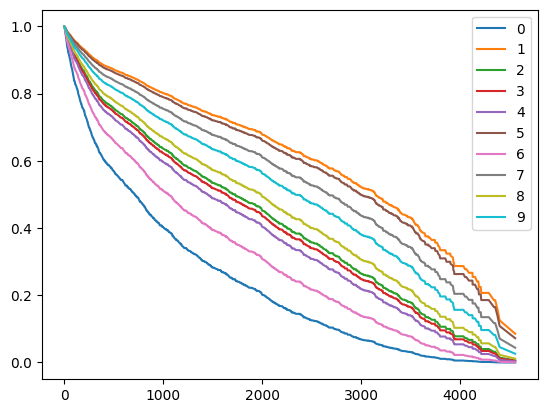

In [6]:
cph.predict_survival_function(x_test.iloc[:10]).plot()

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.7098916540324668
integrated brier score 0.16368242866962265


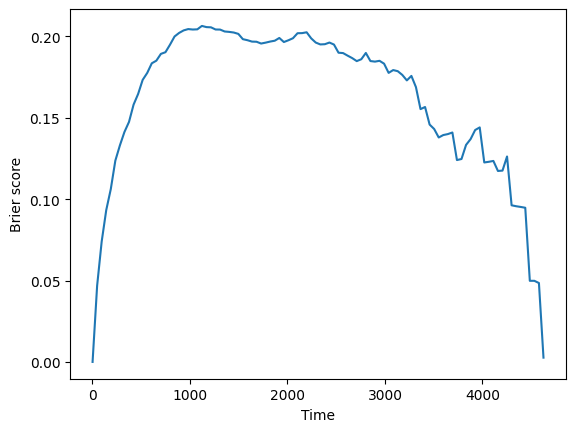

In [7]:
## td-concordance

surv_cph = cph.predict_survival_function(x_test.iloc[: , :-2])

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_cph), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **Param**

In [8]:
from lifelines import WeibullAFTFitter

aft = WeibullAFTFitter(penalizer = 0.01)
eps = 1e-8
x_train['time_to_event'] = x_train['time_to_event'] + eps
aft.fit(x_train, duration_col='time_to_event', event_col='death')

# aft.print_summary(3)  # access the results using aft.summary

<lifelines.WeibullAFTFitter: fitted with 4242 total observations, 2797 right-censored observations>

<Axes: >

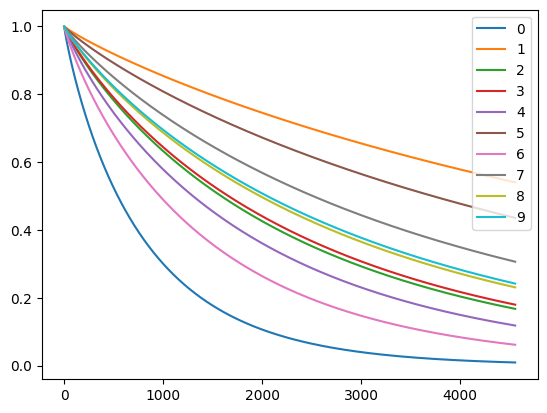

In [9]:
aft.predict_survival_function(x_test.iloc[:10]).plot()

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.7115408793403099
integrated brier score 0.16495339882848595


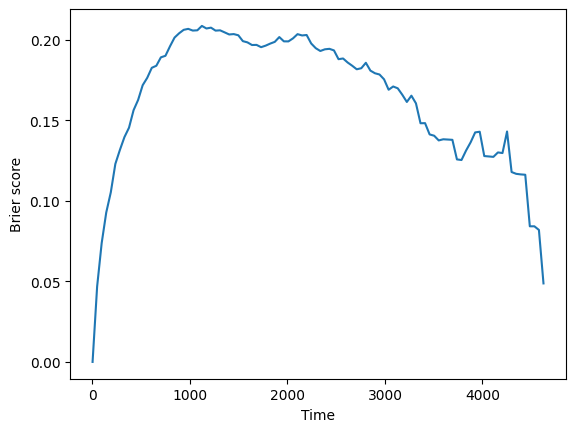

In [10]:
## td-concordance

surv_aft = aft.predict_survival_function(x_test.iloc[: , :-2])

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_aft), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **RSF**

In [11]:
# Train - Create a structured array
y_train = np.array([(x, y) for x, y in zip(x_train['death'].astype('bool') , x_train['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Test - Create a structured array
y_test = np.array([(x, y) for x, y in zip(x_test['death'].astype('bool') , x_test['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])

# Val - Create a structured array
y_val = np.array([(x, y) for x, y in zip(x_val['death'].astype('bool') , x_val['time_to_event'])],
                            dtype=[('death', bool) , ('time_to_event', int)])


In [12]:
rsf = RandomSurvivalForest(
    n_estimators=1000, min_samples_split=10, min_samples_leaf=15, n_jobs=-1, random_state=1234, oob_score = True
)
rsf.fit(x_train.iloc[: , :-2], y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, oob_score=True,
                     random_state=1234)

In [13]:
# Concordance
rsf.score(x_test.iloc[: , :-2], y_test) , rsf.score(x_val.iloc[: , :-2], y_val)

(0.7167178197685168, 0.7082840347813022)

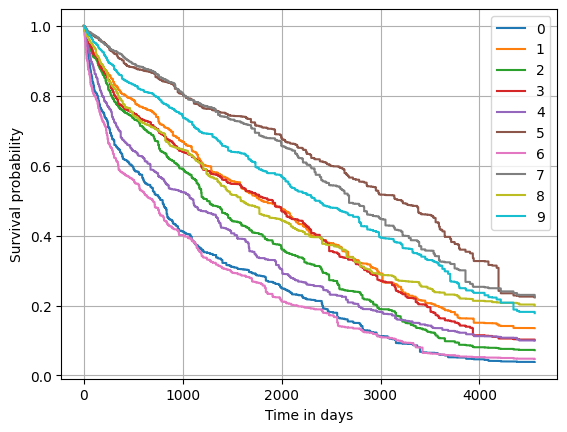

In [14]:
surv_10 = rsf.predict_survival_function(x_test.iloc[: , :-2][:10], return_array=True)

for i, s in enumerate(surv_10):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.7117035831823393
integrated brier score 0.19715333717622935


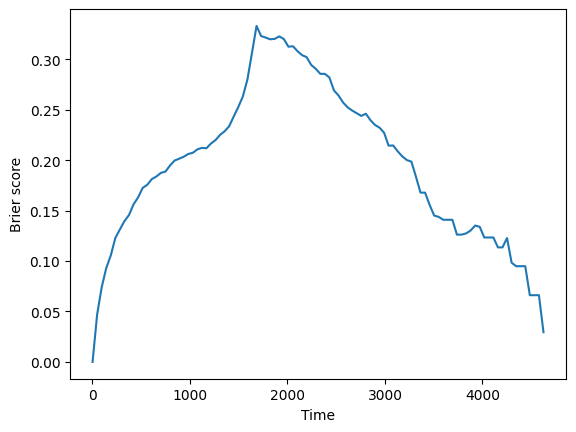

In [15]:
## td-concordance

surv_rsf = rsf.predict_survival_function(x_test.iloc[: , :-2], return_array=True)

from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(surv_rsf.T), x_test['time_to_event'].to_numpy(), x_test['death'].to_numpy(), censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(x_test['time_to_event'].min(), x_test['time_to_event'].max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **PyCox**

0:	[0s / 0s],		train_loss: 1.7462,	val_loss: 1.5651
1:	[0s / 0s],		train_loss: 1.5270,	val_loss: 1.4015
2:	[0s / 0s],		train_loss: 1.3012,	val_loss: 1.1749
3:	[0s / 0s],		train_loss: 1.0998,	val_loss: 0.9845
4:	[0s / 0s],		train_loss: 0.9314,	val_loss: 0.8446
5:	[0s / 1s],		train_loss: 0.8276,	val_loss: 0.7832
6:	[0s / 1s],		train_loss: 0.7870,	val_loss: 0.7670
7:	[0s / 1s],		train_loss: 0.7706,	val_loss: 0.7441
8:	[0s / 1s],		train_loss: 0.7553,	val_loss: 0.7341
9:	[0s / 1s],		train_loss: 0.7399,	val_loss: 0.7330
10:	[0s / 1s],		train_loss: 0.7305,	val_loss: 0.7393
11:	[0s / 2s],		train_loss: 0.7239,	val_loss: 0.7320
12:	[0s / 2s],		train_loss: 0.7286,	val_loss: 0.7300
13:	[0s / 2s],		train_loss: 0.7228,	val_loss: 0.7270
14:	[0s / 2s],		train_loss: 0.7091,	val_loss: 0.7341
15:	[0s / 2s],		train_loss: 0.7062,	val_loss: 0.7249
16:	[0s / 2s],		train_loss: 0.7021,	val_loss: 0.7294
17:	[0s / 3s],		train_loss: 0.6992,	val_loss: 0.7370
18:	[0s / 3s],		train_loss: 0.6916,	val_loss: 0.7348
19:

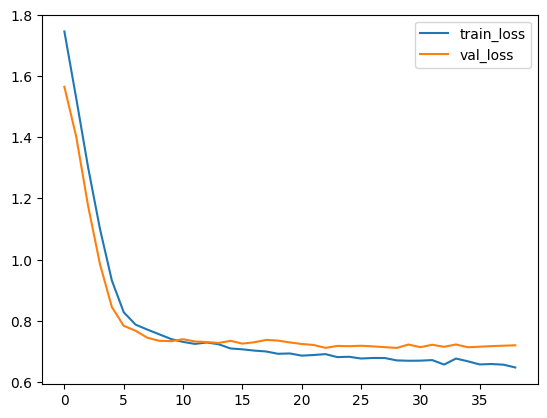

In [16]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)

# one liner func
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_train = labtrans.fit_transform(*get_target(x_train))
y_val = labtrans.transform(*get_target(x_val))

train = (x_train.iloc[: , :-2].to_numpy().astype('float32'), y_train)
val = (x_val.iloc[: , :-2].to_numpy().astype('float32'), y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(x_test)

in_features = x_train.iloc[: , :-2].shape[1]
num_nodes = [256,256]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.5

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

model = LogisticHazard(net, tt.optim.Adam(0.002), duration_index=labtrans.cuts)

batch_size = 256
epochs = 500
callbacks = [tt.cb.EarlyStopping()]

log = model.fit(x_train.iloc[:,:-2].to_numpy().astype('float32'), y_train, batch_size, epochs, callbacks, val_data=val)

_ = log.plot()

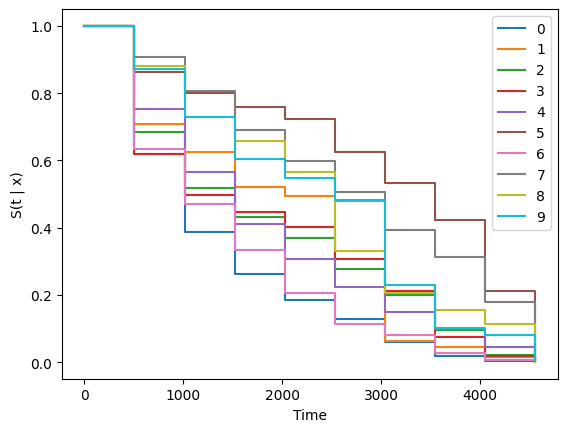

In [17]:
surv = model.predict_surv_df(x_test.iloc[: , :-2].to_numpy().astype('float32'))

surv.iloc[:, :10].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.5928780090966239
integrated brier score 0.16724646208424054


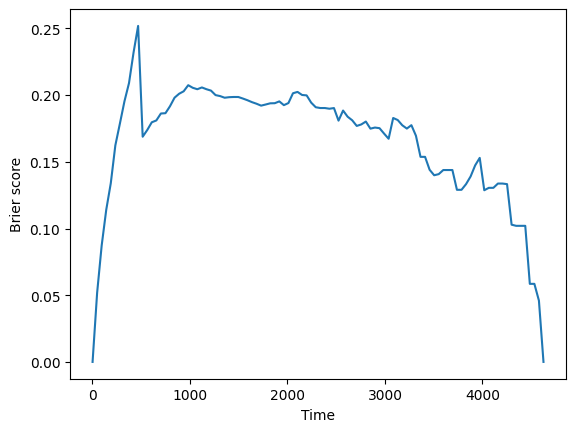

In [18]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **Deep Survival Machines**

In [19]:
import auton_survival
from auton_survival import datasets
from auton_survival.preprocessing import Preprocessor
from auton_survival.models.dsm import DeepSurvivalMachines
import numpy as np

# horizons = [0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.0]
# times = np.quantile(consolidated_pat_tbl['time_to_event'].to_numpy()[consolidated_pat_tbl['death'].to_numpy()==1], horizons).tolist()
times = list(labtrans.cuts[:])
# times

In [20]:
param_grid = {'k' : [3,4,6],
              'distribution' : ['LogNormal', 'Weibull'],
              'learning_rate' : [1e-4, 1e-3],
              'layers' : [ [], [100], [100, 100] ]
             }

params = ParameterGrid(param_grid)

models = []
for param in params:
    model = DeepSurvivalMachines(k = param['k'],
                                 distribution = param['distribution'],
                                 layers = param['layers'])
    # The fit method is called to train the model
    model.fit(x_train.iloc[: , :-2].to_numpy(), x_train['time_to_event'].to_numpy(), x_train['death'].to_numpy() ,
              iters = 100 , 
              learning_rate = param['learning_rate']
            )
    models.append([[model.compute_nll(x_val.iloc[: , :-2].to_numpy(), x_val['time_to_event'].to_numpy(), x_val['death'].to_numpy()), 
                    model]])
best_model = min(models)
model = best_model[0][1]

  0%|          | 0/10000 [00:00<?, ?it/s]

 23%|██▎       | 23/100 [00:07<00:24,  3.17it/s]


In [21]:
# Inference
out_risk = model.predict_risk(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)
out_survival = model.predict_survival(x_test.iloc[: , :-2].to_numpy().astype('float64'), times)

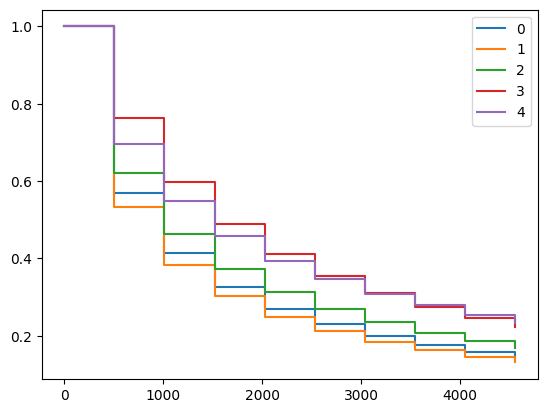

In [22]:
for i , surv in enumerate(out_survival[20:25 , :]):
    plt.step(times , surv , where = 'post' , label = i)
    plt.legend()

shapes : (1060, 1060, 1060, 1060)
td-concordance 0.6747624154124913
integrated brier score 0.26369598710577996


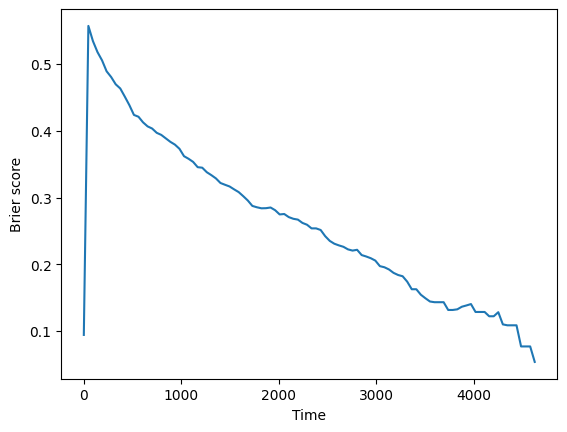

In [23]:
from eval_surv_copy import EvalSurv
ev = EvalSurv(pd.DataFrame(out_survival.T), durations_test, events_test, censor_surv='km')
print(f"td-concordance {ev.concordance_td('antolini')}")

time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev.integrated_brier_score(time_grid) }')

#### **DeepSurv**

In [24]:
# Simple feedforward NN to implement DeepSurv

class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x))
        return output

In [25]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def PartialLogLikelihood(self , logits, fail_indicator, ties = 'noties'):
        '''
        fail_indicator: 1 if the sample fails, 0 if the sample is censored.
        logits: raw output from model 
        ties: 'noties' or 'efron' or 'breslow'
        reference -> https://github.com/runopti/stg/blob/master/python/stg/losses.py
        '''
        logL = 0
        # pre-calculate cumsum
        # cumsum_y_pred = torch.cumsum(logits, 0)
        hazard_ratio = torch.exp(logits)
        cumsum_hazard_ratio = torch.cumsum(hazard_ratio, 0)
        if ties == 'noties':
            log_risk = torch.log(cumsum_hazard_ratio)
            likelihood = logits - log_risk
            # dimension for E: np.array -> [None, 1]
            uncensored_likelihood = likelihood * fail_indicator
            logL = -torch.sum(uncensored_likelihood)
        else:
            raise NotImplementedError()
        # negative average log-likelihood
        observations = torch.sum(fail_indicator, 0)
        return 1.0*logL / observations

In [26]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, events):
        self.data = features
        self.events = events
        assert self.data.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        eve = self.events[index] # events
        return cov , eve

In [27]:
input_size = x_train.iloc[: , :-2].shape[1]
output_size = 1 # the output is the hazard

# Create an instance of your custom dataset
dataset = MyDataset(torch.Tensor(x_train.iloc[: , :-2].to_numpy()).to(torch.float32), 
                    torch.Tensor(x_train.iloc[: , -1].to_numpy()).to(torch.float32)
                    )

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 1000
learning_rate = 0.01
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
patience = 50

# build net
# net = MLP(input_size , hidden_size , output_size)
net = MLP(
    input_size =  input_size, 
    hidden_size = 100 , 
    output_size = output_size,
    dropout_rate = 0.1
)

# init optim
optimizer = torch.optim.Adam(net.parameters() , lr = learning_rate)

In [28]:
l = generic_Loss()

best_loss = np.Inf

cov_val = torch.Tensor(x_val.iloc[: , :-2].to_numpy()).to(torch.float32)
eve_val = torch.Tensor(x_val.iloc[: , -1].to_numpy()).to(torch.float32)

# Training loop
for epoch in range(num_epochs):
    for batch_id , (cov , eve) in enumerate(dataloader):
        # Prime for training
        net.train()

        # forward pass
        phi_train = net(cov)

        # get loss
        loss = l.PartialLogLikelihood(logits = phi_train , fail_indicator = eve)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Early stopping
        # Prime for evaluation
        net.eval()
        with torch.no_grad():
            phi_val = net(cov_val)
            val_loss = l.PartialLogLikelihood(logits = phi_val , fail_indicator = eve_val)
        
        # Check if validation loss has improved
        if val_loss < best_loss:
            best_loss = val_loss
            counter = 0
        else:
            counter += 1

        # Check if early stopping condition is met
        if counter >= patience:
            # print(f"Early stopping at epoch {epoch}.")
            break


    if (epoch%50==0): print(f"Epoch {epoch+1}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 

Epoch 1: Training Loss: 592.8139, Val Loss: 8280.3721
Epoch 51: Training Loss: 1171.7439, Val Loss: 8219.4053
Epoch 101: Training Loss: 1169.2333, Val Loss: 8205.2334
Epoch 151: Training Loss: 1169.1018, Val Loss: 8228.7812
Epoch 201: Training Loss: 1172.1288, Val Loss: 8203.8711
Epoch 251: Training Loss: 1166.3177, Val Loss: 8214.0811
Epoch 301: Training Loss: 1168.0510, Val Loss: 8209.3213
Epoch 351: Training Loss: 1168.7103, Val Loss: 8215.6289
Epoch 401: Training Loss: 1167.6686, Val Loss: 8206.9014
Epoch 451: Training Loss: 1169.3893, Val Loss: 8205.7090
Epoch 501: Training Loss: 1177.3065, Val Loss: 8260.6631
Epoch 551: Training Loss: 1166.9622, Val Loss: 8209.7725
Epoch 601: Training Loss: 1167.0031, Val Loss: 8205.8936
Epoch 651: Training Loss: 1167.6409, Val Loss: 8207.4150
Epoch 701: Training Loss: 1168.2853, Val Loss: 8204.0293
Epoch 751: Training Loss: 1167.8192, Val Loss: 8203.7686
Epoch 801: Training Loss: 1170.7454, Val Loss: 8211.6553
Epoch 851: Training Loss: 1168.3066

In [29]:
cov_test = torch.Tensor(x_test.iloc[: , :-2].to_numpy()).to(torch.float32)
dur_test = torch.Tensor(x_test.iloc[: , -2].to_numpy()).to(torch.float32)
eve_test = torch.Tensor(x_test.iloc[: , -1].to_numpy()).to(torch.float32)
print(f'test shape: {cov_test.shape}')

with torch.no_grad():
    risk_test = torch.exp(net(cov_test))

concordance_index(dur_test, risk_test, eve_test) 

test shape: torch.Size([1060, 45])


0.555167695891728

#### **My Model**

#### **Time Independent**

Flow
_____
1. measure similarity
2. cluster
3. build cluster-wise nn
4. predict

In [30]:
# Clustering
from sklearn.cluster import KMeans

# Specify the number of clusters (K)
_clusters = 1

# Create a KMeans instance and fit the data
kmeans = KMeans(n_clusters=_clusters , n_init = 'auto')
kmeans.fit(x_train.iloc[: , :-2])

# Add cluster
x_train['cluster'] = kmeans.labels_

x_train_grouped = x_train.groupby('cluster')

# drop cluster to avoid shape problems
x_train.drop('cluster' , axis = 1 , inplace = True)

assert x_train.shape[1] == x_val.shape[1] == x_test.shape[1]

In [31]:
def plot_cluster_hist(arr: np.array):
    cluster_counts = Counter(arr)
    # Sort the Counter object by keys in ascending order
    sorted_countes = OrderedDict(sorted(cluster_counts.items()))
    
    # Extract the category labels and their corresponding counts
    labels = list(sorted_countes.keys())
    counts = list(sorted_countes.values())

    # Plot the histogram
    plt.bar(labels, counts);

    # Set the labels and title
    plt.xlabel('Categories')
    plt.ylabel('Counts')
    plt.title('Categorical Histogram')
    plt.xticks(labels)

    for i, value in enumerate(counts):
        plt.text(i, value + 1, str(value), ha='center', va='bottom')

    plt.show()

In [32]:
test_clusters = kmeans.predict(x_test.iloc[: , :-2])
# plot_cluster_hist(test_clusters)

# Add cluster
x_test['cluster'] = test_clusters

x_test_grouped = x_test.groupby('cluster')

# drop cluster to avoid shape problems
x_test.drop('cluster' , axis = 1 , inplace = True)

val_clusters = kmeans.predict(x_val.iloc[: , :-2])
# plot_cluster_hist(test_clusters)

# Add cluster
x_val['cluster'] = val_clusters

x_val_grouped = x_val.groupby('cluster')

# drop cluster to avoid shape problems
x_val.drop('cluster' , axis = 1 , inplace = True)

In [33]:
class generic_Loss(torch.nn.Module):
    '''
    Generic Loss Function
    '''
    def __init__(self, reduction: str = 'mean') -> None:
        super().__init__()
        self.reduction = reduction

    def nll_logistic_hazard(self , logits , targets , dur_idx):
        '''
        logits - parameterized inv.logit(hazards) from nn
        targets - survival matrix 
        '''
        logits = torch.Tensor(logits)
        targets = torch.Tensor(targets)
        dur_idx = torch.Tensor(dur_idx).to(torch.int64).view(-1 , 1)

        loss = F.binary_cross_entropy_with_logits(input = logits , target = targets , reduction = 'none')
        
        assert loss.shape == targets.shape , 'must match'

        # cumulative hazards
        loss = loss.cumsum(1)
        loss = loss.gather(1, dur_idx)
        
        return loss.view(-1).mean()

In [34]:
class MLP(nn.Module):
    def __init__(self , input_size , hidden_size , output_size , dropout_rate = 0.1):
        super(MLP , self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size), nn.ReLU(), nn.BatchNorm1d(hidden_size), nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, output_size)
        )

    def forward(self , x):
        # forward pass
        output = self.network(torch.Tensor(x).to(torch.float32))
        return output   

In [35]:
class MyDataset(Dataset):
    '''
    simple data set class
    '''
    def __init__(self, features, durations, events):
        self.data = features
        self.durations = durations
        self.events = events
        assert self.data.shape[0] == self.durations.shape[0] == self.events.shape[0] , 'shapes must match!'

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        cov = self.data[index] # covariates
        dur = self.durations[index] # durations
        eve = self.events[index] # events
        return cov , dur , eve

In [36]:
class Surv_Matrix:
    def __init__(self , duration_index , events , q_cuts=10):
        self.duration_index = duration_index
        self.events = events
        self.q_cuts = q_cuts
    
    def make_survival_matrix(self):
        '''
        converts durations and index into a matrix denoting time of event
        this is the y_ij matrix as shown in Kvamme's paper
        '''
        self.surv_matrix = torch.eye(self.q_cuts)[self.duration_index] 
        self.surv_matrix = self.surv_matrix*self.events.reshape(-1 , 1) # censoring mask
        return self.surv_matrix

In [37]:
class Transforms:
    def __init__(self , durations):
        self.durations = durations
        
    def discrete_transform(self , _cuts):
        '''
        cut at even spaces
        '''
        self.bin_edges = np.linspace(self.durations.min() , self.durations.max() , _cuts) # right-side edges of the bins
        self.duration_index = np.searchsorted(a = self.bin_edges , v = self.durations)
        self.n_duration_index = self.duration_index.max()+1
        # print(self.n_duration_index)
        assert self.n_duration_index == _cuts , 'must match'
        return self.duration_index

In [38]:
q_cuts = 15 # number of discretized durations

# Prepare val and test data
get_target = lambda df: (df['time_to_event'].values, df['death'].values)
y_test_dur , y_test_event = get_target(x_test)
y_val_dur , y_val_event = get_target(x_val)

t_test = Transforms(durations = y_test_dur)
dur_idx_test = t_test.discrete_transform(_cuts = q_cuts)

t_val = Transforms(durations = y_val_dur)
dur_idx_val = t_val.discrete_transform(_cuts = q_cuts)

# # We don't need to transform the test labels
# durations_test, events_test = get_target(x_test)

In [46]:
input_size = x_train.iloc[: , :-2].shape[1]
hidden_size = 32
output_size = t_test.n_duration_index

# Create a data loader for batching and shuffling
batch_size = 256
num_epochs = 500
learning_rate = 0.001
shuffle = True
patience = 20
dropout = 0.5

# build net(s)
nets = []

# init as many networks as there are clusters
for grp in x_train_grouped.groups.keys():
    # init net
    mlp = MLP(input_size , hidden_size , output_size , dropout_rate = dropout)
    # init optim
    optimizer = torch.optim.Adam(mlp.parameters() , lr = learning_rate)
    # append
    nets.append((mlp , optimizer))

In [47]:
sm_val = Surv_Matrix(duration_index = dur_idx_val , events = y_val_event , q_cuts = q_cuts)
surv_mat_val = sm_val.make_survival_matrix()

# init loss
l = generic_Loss()

# init loss for early stopping
best_loss = np.Inf

In [48]:
for i , grp in enumerate(x_train_grouped.groups.keys()): 
    print(f'training cluster {i}')
    # get features, death time and event indicator
    features = x_train_grouped.get_group(grp)#.reset_index().drop('index' , axis = 1)
    
    y_train_dur , y_train_event = get_target(features)

    t_train = Transforms(durations = y_train_dur)
    dur_idx = t_train.discrete_transform(_cuts = q_cuts)

    # event = features.iloc[: , -1].to_numpy()
    features = features.iloc[: , :-2].to_numpy() # curtail  features column

    # Create an instance of your custom dataset
    dataset = MyDataset(features, dur_idx , y_train_event) # need to change outcomes[0] to indexed version
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

    # Training loop
    for epoch in range(num_epochs):
        for batch_id , (patient_image , dur , eve) in enumerate(dataloader):
            # get mlp and optimizer
            net = nets[i][0]
            optimizer = nets[i][1]

            # Prime for training
            net.train()
            
            # forward pass
            phi_train = net(patient_image)

            # make survival matrix
            sm = Surv_Matrix(duration_index = dur, events = eve , q_cuts = q_cuts)
            surv_mat = sm.make_survival_matrix()        

            # get loss
            loss = l.nll_logistic_hazard(logits = phi_train , targets = surv_mat , dur_idx = dur)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Early stopping
            with torch.no_grad():
                phi_val = net(x_val.iloc[: , :-2].to_numpy())
                val_loss = l.nll_logistic_hazard(logits = phi_val, targets = surv_mat_val , dur_idx = dur_idx_val)
            
            # Check if validation loss has improved
            if val_loss < best_loss:
                best_loss = val_loss
                counter = 0
            else:
                counter += 1

            # Check if early stopping condition is met
            if counter >= patience:
                # print(f"Early stopping at epoch {epoch}.")
                break

        if (epoch%50==0): print(f"Epoch {epoch}: Training Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}") 


training cluster 0
Epoch 0: Training Loss: 2.8640, Val Loss: 2.9519
Epoch 50: Training Loss: 1.1358, Val Loss: 1.0847
Epoch 100: Training Loss: 1.1198, Val Loss: 1.0543
Epoch 150: Training Loss: 1.0096, Val Loss: 1.0293
Epoch 200: Training Loss: 1.0348, Val Loss: 1.0064
Epoch 250: Training Loss: 1.0319, Val Loss: 1.0141
Epoch 300: Training Loss: 1.0094, Val Loss: 1.0112
Epoch 350: Training Loss: 0.8813, Val Loss: 1.0165
Epoch 400: Training Loss: 0.9691, Val Loss: 1.0015
Epoch 450: Training Loss: 0.8838, Val Loss: 0.9996


**Testing**

In [49]:
# Testing
surv = [] # length will be equal to number of cluster
mc_iter = 69

# init empty lists for duration and event 
y_test_dur = []
y_test_event = []

# predict for each cluster
for i , grp in enumerate(x_test_grouped.groups.keys()):
    
    # get features, death time and event indicator
    features = x_test_grouped.get_group(grp)

    # get death time and event indicator
    y_test_dur_ , y_test_event_ = get_target(features)
    y_test_dur.append(y_test_dur_)
    y_test_event.append(y_test_event_)

    # curtail features matrix
    features = features.iloc[: , :-2].to_numpy()

    survival = []

    # apply Monte Carlo dropout
    for _ in range(mc_iter):
        net = nets[i][0]
        
        # Prime dropout layers
        net.train()
        
        # predict
        mc_haz = torch.sigmoid(net(features))
        mc_survival = torch.log(1 - mc_haz).cumsum(1).exp().detach().numpy()
        
        # append survivals from different runs
        survival.append(mc_survival)
    
    # convert to 3d array
    survival = np.array(survival)
    
    surv.append(survival)


# Concatenate durations and event indicators 
y_test_dur = np.concatenate(y_test_dur , axis = 0)
y_test_event = np.concatenate(y_test_event , axis = 0)

# QCs
assert len(surv) == _clusters , 'surv matrix not matching number of clusters'
assert len(x_test) == np.sum([surv[k].shape[1] for k in range(_clusters)]) , 'test set count mismatch'

mean_ = np.concatenate([surv[k].mean(axis = 0) for k in range(_clusters)])
up_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = 0.95) for k in range(_clusters)])
low_ = np.concatenate([np.quantile(surv[k] , axis = 0 , q = 0.05) for k in range(_clusters)])

# QCs
assert mean_.shape[0] == up_.shape[0] == low_.shape[0] == y_test_dur.shape[0] == y_test_event.shape[0] , 'shape mismatch'

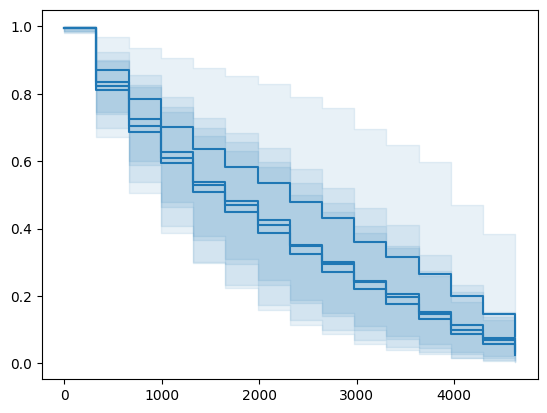

In [50]:
def plot_with_cf(mean_ , low_ , up_ , _from , _to = None):
    if _to is not None:
        for _ , (m , l , u) in enumerate(zip(mean_[_from:_to] , low_[_from:_to] , up_[_from:_to])):
            plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean' , color = 'C0');
            plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.1 , label = 'confint' , color = 'C0');
    else:
        m , l , u = mean_[_from] , low_[_from] , up_[_from]
        plt.step(t_test.bin_edges , m , where = 'post' , label = 'mean' , color = 'C0');
        plt.fill_between(t_test.bin_edges , l , u , step = 'post' , alpha = 0.2 , label = 'confint' , color = 'C0');

plot_with_cf(mean_ , low_ , up_ , _from = 1 , _to = 5)

shapes : (1060, 1060, 1060, 1060)
concordance-td: 0.7116246829095628
integrated brier score 0.3616159361808128


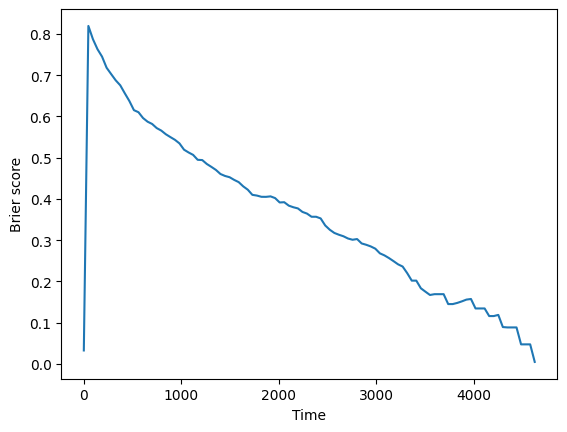

In [51]:
# Evaluation

ev_ = EvalSurv(pd.DataFrame(mean_.T) , y_test_dur , y_test_event , censor_surv='km')
print(f'concordance-td: {ev_.concordance_td()}')

time_grid = np.linspace(y_test_dur.min(), y_test_dur.max(), 100)
ev_.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

print(f'integrated brier score {ev_.integrated_brier_score(time_grid) }')

**Explainer**

In [45]:
%%time
# SHAP Values
grp = 0

background = x_val_grouped.get_group(grp)
background = torch.Tensor(background.iloc[: , :-2].to_numpy()) # curtail  features column

testing_data = x_test_grouped.get_group(grp)
testing_data = torch.Tensor(testing_data.iloc[: , :-2].to_numpy()) # curtail  features column

explainer = shap.DeepExplainer(nets[i][0] , background)
shap_values = explainer.shap_values(testing_data)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


KeyboardInterrupt: 

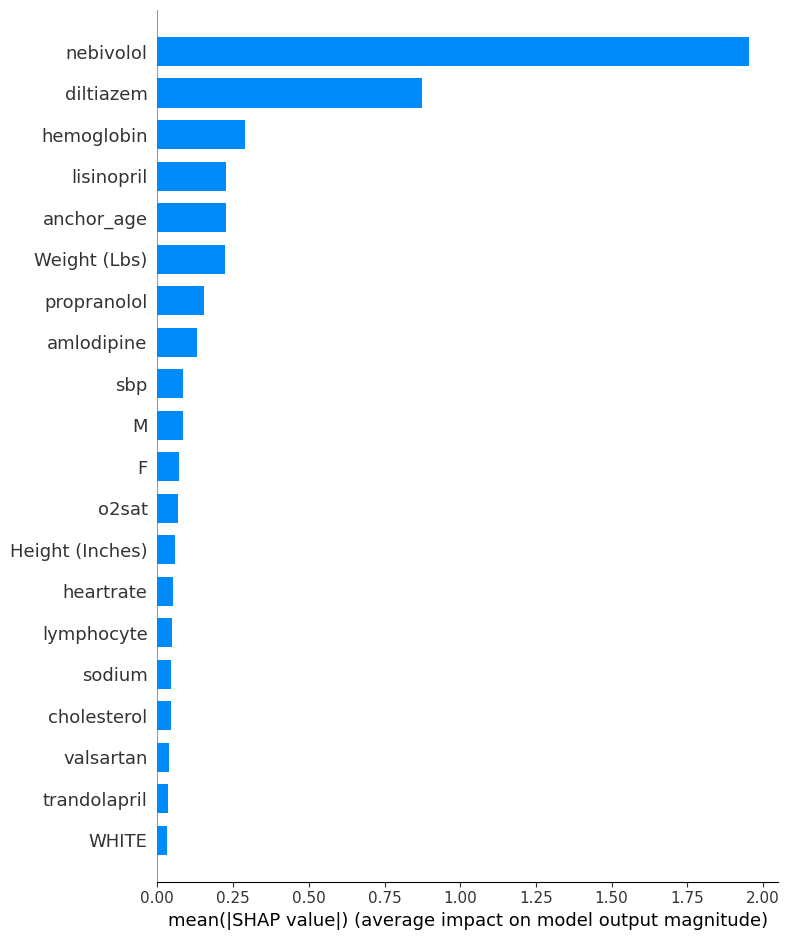

In [ ]:
shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features = x_test_grouped.get_group(grp).iloc[: , :-2].columns)

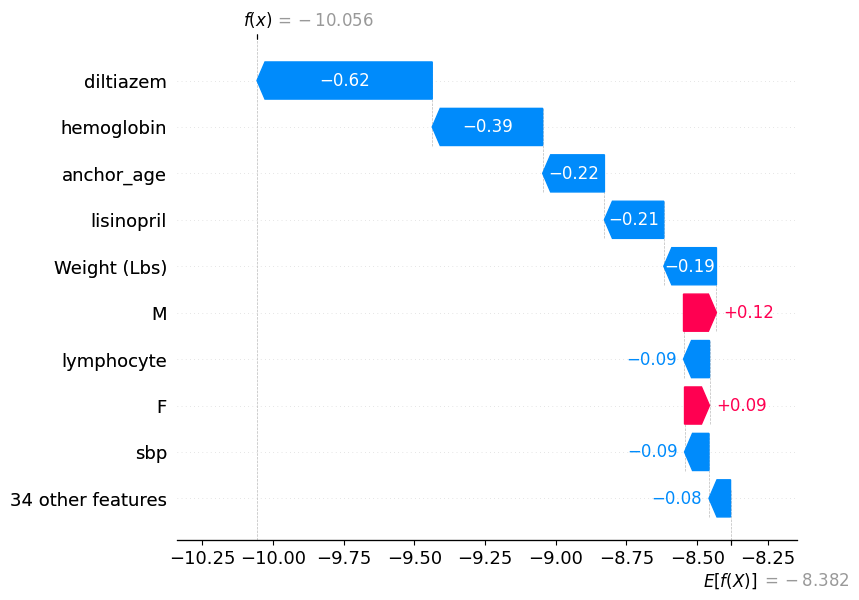

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], 
                                       feature_names = x_test_grouped.get_group(grp).iloc[: , :-2].columns)